In [1]:
import requests
import io
import datetime

import numpy as np
import pandas as pd
import matplotlib.pylab as plt

In [2]:
from prophet import Prophet
from prophet.plot import add_changepoints_to_plot
from statsmodels.stats.diagnostic import acorr_ljungbox
import statsmodels.api as sm
from scipy import stats

In [3]:
INPUT_DIR = "input/"

In [4]:
start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2021, 1, 1)

In [5]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_train = df[(df['ds'] < start)]
df_test = df[(df['ds']>= start) & (df['ds'] < end)]

In [6]:
def plot_prediction(forecast, data_test):
    output = pd.merge(forecast, data_test, on='ds', how='left').set_index('ds')

    cond = (output.index >= start) & (output.index < end)
    actual = output[cond]['y']
    pred = output[cond]['yhat']

    mape = (np.abs(pred - actual) / actual * 100).mean()

    actual.plot(label='actual')
    pred.plot(label=f'predict, MAPE:{mape:.2f} %')
    plt.legend()
    plt.show()
    
    (pred - actual).plot(label='residual')
    plt.legend()
    plt.show()

In [7]:
def correlation_plot(data, lags=60):
    fig = plt.figure(figsize=(10, 8))
    # 自己相関のコレログラム
    ax1 = fig.add_subplot(2, 1, 1)
    ax1.set_ylim(-1.1, 1.1)
    fig = sm.graphics.tsa.plot_acf(data, lags=lags, ax=ax1)
    # 偏自己相関のコレログラム
    ax2 = fig.add_subplot(2, 1, 2)
    ax2.set_ylim(-1.1, 1.1)    
    fig = sm.graphics.tsa.plot_pacf(data, lags=lags, ax=ax2)
    plt.show()

## 原系列だけでProphet

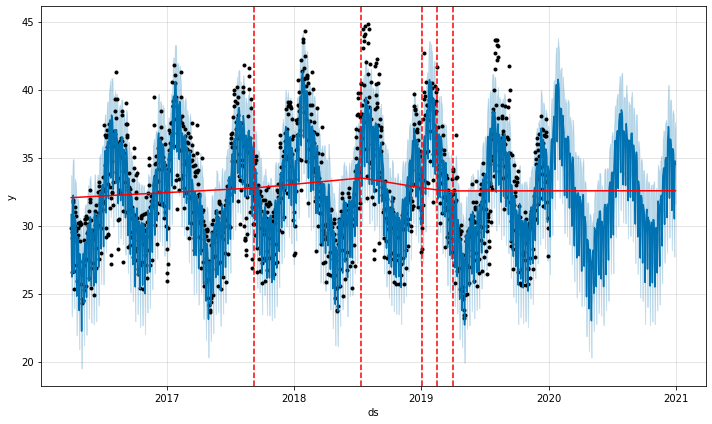

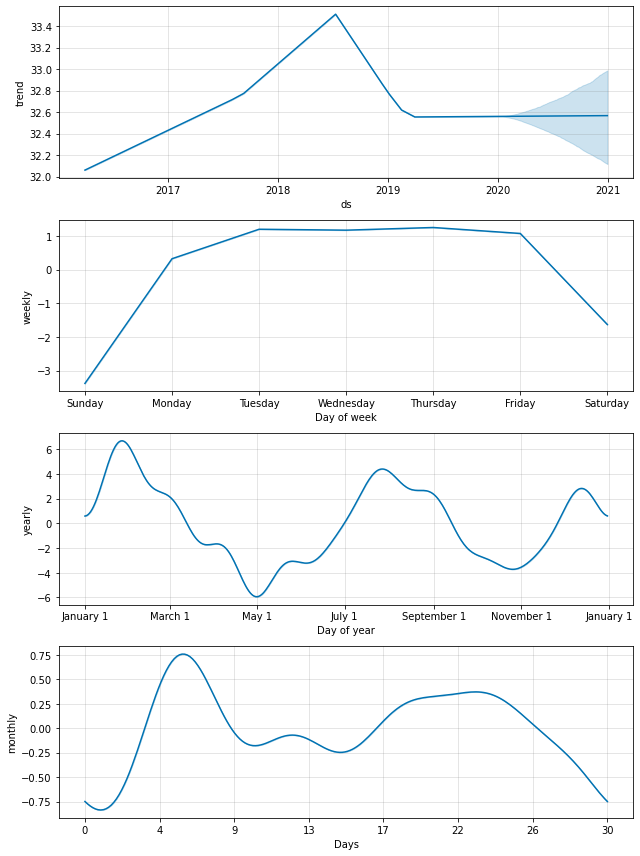

In [8]:
data_train = df_train[['ds', 'y']].copy()
data_test = df_test[['ds', 'y']].copy()

prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=365, freq='D')
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
plt.show()

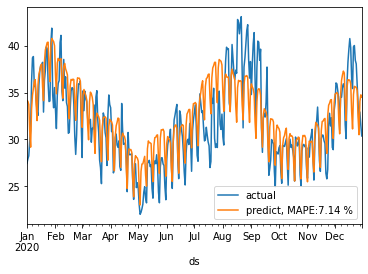

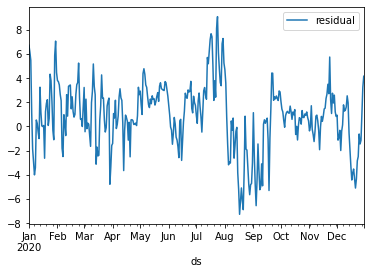

In [9]:
plot_prediction(forecast, data_test)

## 外部変数として気温を追加

In [10]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df

,ds,y,temperature
0,2016-04-01,29.844167,12.8
1,2016-04-02,29.074167,10.5
2,2016-04-03,26.582500,13.1
3,2016-04-04,29.562083,15.6
4,2016-04-05,31.905000,10.8
...,...,...,...
1816,2021-03-22,30.848333,NaN
1817,2021-03-23,31.999167,NaN
1818,2021-03-24,30.931667,NaN
1819,2021-03-25,30.563750,NaN


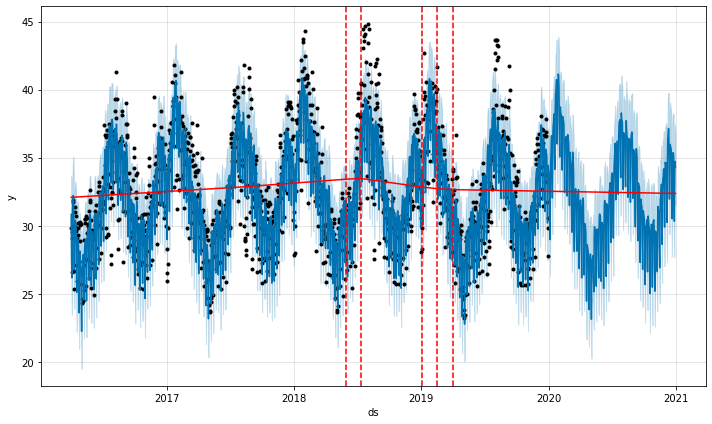

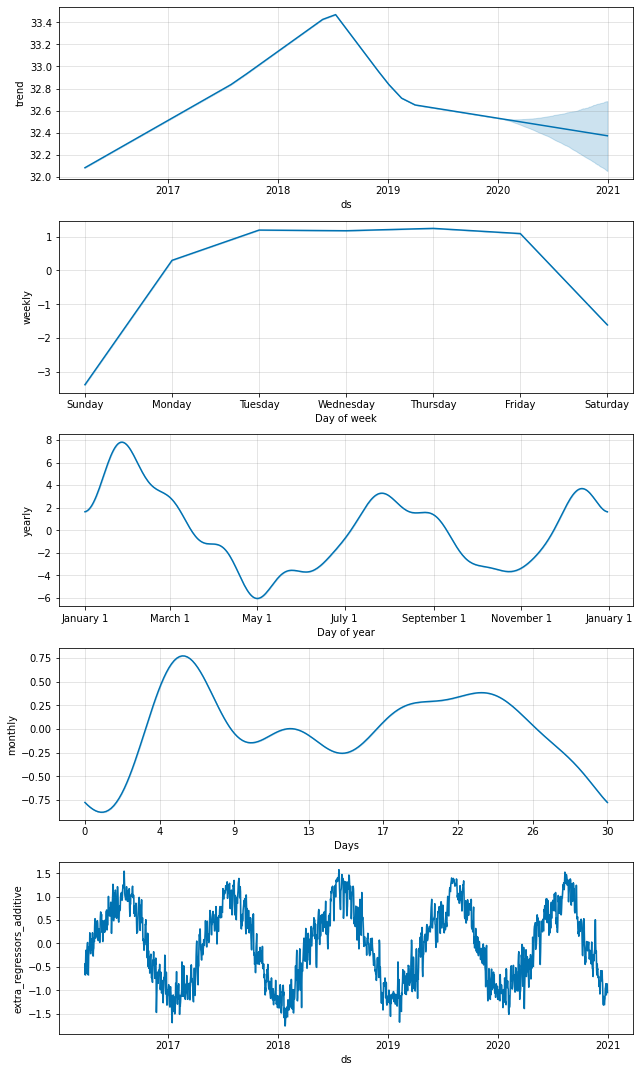

In [11]:
df_train = df[(df['ds'] < start)]
df_test = df[(df['ds']>= start) & (df['ds'] < end)]

data_train = df_train[['ds', 'y', 'temperature']].copy()
data_test = df_test[['ds', 'y', 'temperature']].copy()

prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.add_regressor('temperature')
# prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=365, freq="D")

future = pd.merge(future, df[['ds', 'temperature']], on='ds', how='left')  
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
# data_test.set_index('ds').plot()
plt.show()

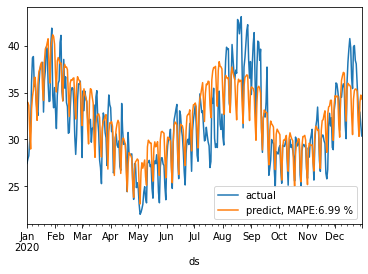

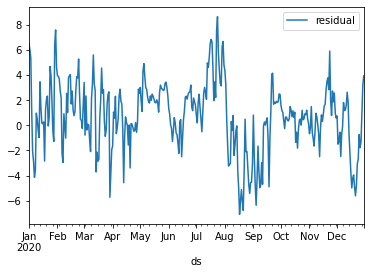

In [12]:
plot_prediction(forecast, data_test)

## 更にGDPを追加

In [13]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')
df

,ds,y,temperature,gdp
0,2016-04-01,29.844167,12.8,134271.6
1,2016-04-02,29.074167,10.5,134271.6
2,2016-04-03,26.582500,13.1,134271.6
3,2016-04-04,29.562083,15.6,134271.6
4,2016-04-05,31.905000,10.8,134271.6
...,...,...,...,...
1816,2021-03-22,30.848333,NaN,NaN
1817,2021-03-23,31.999167,NaN,NaN
1818,2021-03-24,30.931667,NaN,NaN
1819,2021-03-25,30.563750,NaN,NaN


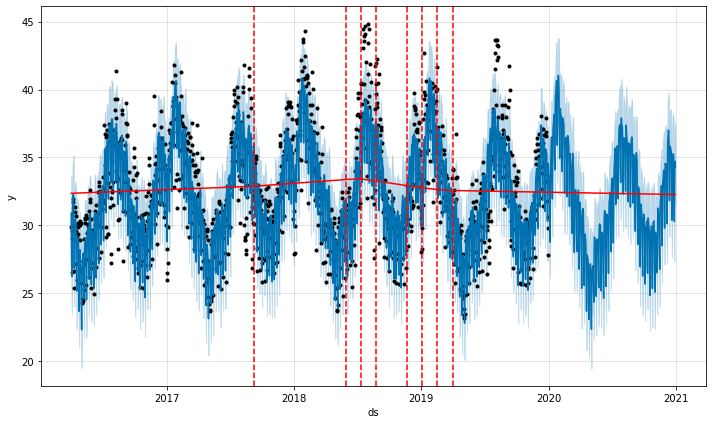

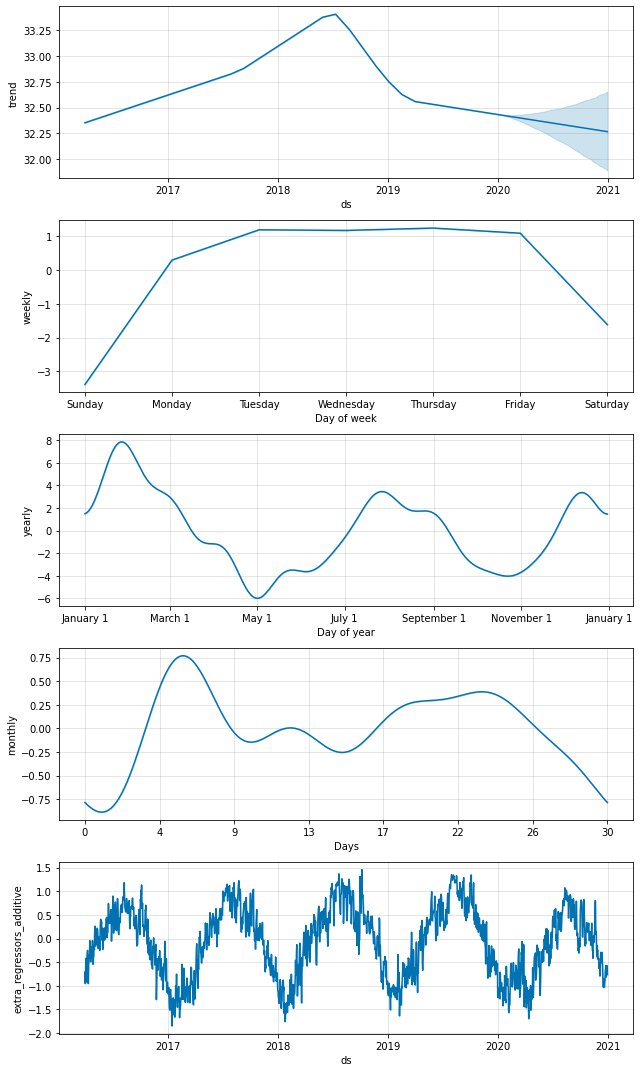

In [14]:
df_train = df[(df['ds'] < start)]
df_test = df[(df['ds']>= start) & (df['ds'] < end)]

data_train = df_train[['ds', 'y', 'temperature', 'gdp']].copy()
data_test = df_test[['ds', 'y', 'temperature', 'gdp']].copy()

prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.add_regressor('temperature')
prophet.add_regressor('gdp')

# prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=365, freq='D')

future = pd.merge(future, df[['ds', 'temperature', 'gdp']], on='ds', how='left')  
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
# data_test.set_index('ds').plot()
plt.show()

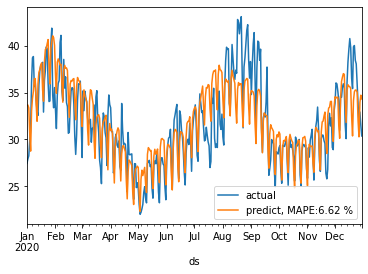

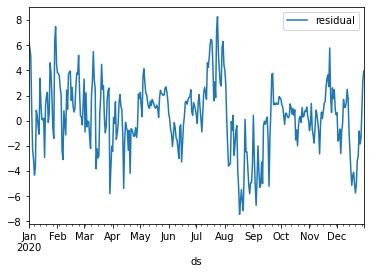

In [15]:
plot_prediction(forecast, data_test)

## 残差の確認

Jack Bera: 	 Jarque_beraResult(statistic=51.551110282516106, pvalue=6.394662577235977e-12)


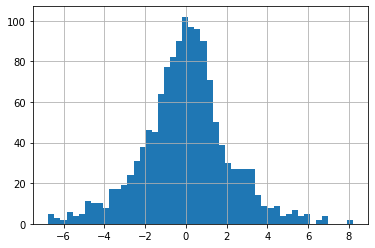

In [16]:
output = pd.merge(forecast, data_train, on='ds', how='left').set_index('ds')

cond = (output.index < start)
actual = output[cond]['y']
pred = output[cond]['yhat']

diff_arr = pred - actual

diff_arr.hist(bins=50)

jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

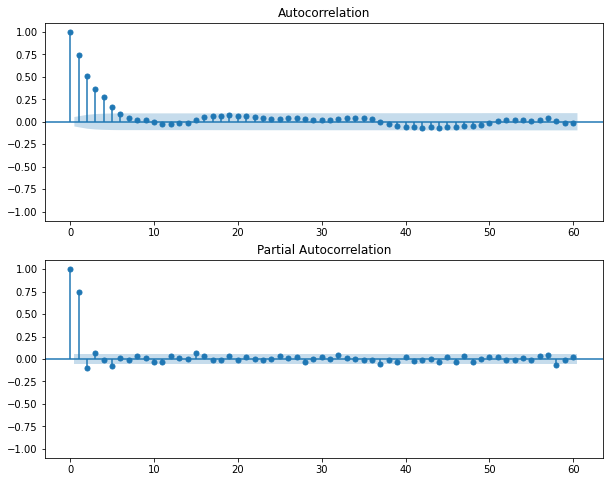

1 758.9867785114748 4.4603378249808415e-167
2 1111.1761947647894 5.1422726017202916e-242
3 1299.295110110064 2.0930494548432844e-281
4 1399.97079778051 7.013145046028478e-302
5 1435.9068206408654 2.281449560313347e-308
6 1446.589096200145 1.97683414580905e-309
7 1448.9442864474395 9.902003996876557e-309
8 1449.7968216915367 9.662711002782778e-308
9 1450.2694794074955 1.0614597183779329e-306
10 1450.2696401181076 1.3861549271270494e-305


/home/rnomura/.cache/pypoetry/virtualenvs/timeseries-KrZpyNEk-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [17]:
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

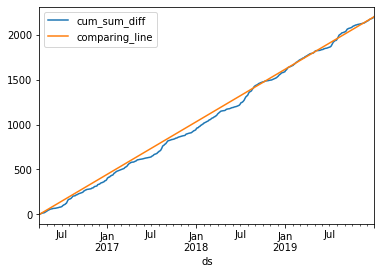

In [18]:
cum_arr = diff_arr.apply(np.abs).cumsum()

cum_min = cum_arr.min()
cum_max = cum_arr.max()

se_line = pd.Series(np.linspace(cum_min, cum_max, len(diff_arr)), index=diff_arr.index)

cum_arr.plot(label='cum_sum_diff')
se_line.plot(label='comparing_line')
plt.legend()
plt.show()

## 自己回帰項を入れる

In [19]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')
df

,ds,y,temperature,gdp
0,2016-04-01,29.844167,12.8,134271.6
1,2016-04-02,29.074167,10.5,134271.6
2,2016-04-03,26.582500,13.1,134271.6
3,2016-04-04,29.562083,15.6,134271.6
4,2016-04-05,31.905000,10.8,134271.6
...,...,...,...,...
1816,2021-03-22,30.848333,NaN,NaN
1817,2021-03-23,31.999167,NaN,NaN
1818,2021-03-24,30.931667,NaN,NaN
1819,2021-03-25,30.563750,NaN,NaN


In [20]:
df['y_shift_1'] = df['y'].shift(1).bfill()
df

,ds,y,temperature,gdp,y_shift_1
0,2016-04-01,29.844167,12.8,134271.6,29.844167
1,2016-04-02,29.074167,10.5,134271.6,29.844167
2,2016-04-03,26.582500,13.1,134271.6,29.074167
3,2016-04-04,29.562083,15.6,134271.6,26.582500
4,2016-04-05,31.905000,10.8,134271.6,29.562083
...,...,...,...,...,...
1816,2021-03-22,30.848333,NaN,NaN,26.930833
1817,2021-03-23,31.999167,NaN,NaN,30.848333
1818,2021-03-24,30.931667,NaN,NaN,31.999167
1819,2021-03-25,30.563750,NaN,NaN,30.931667


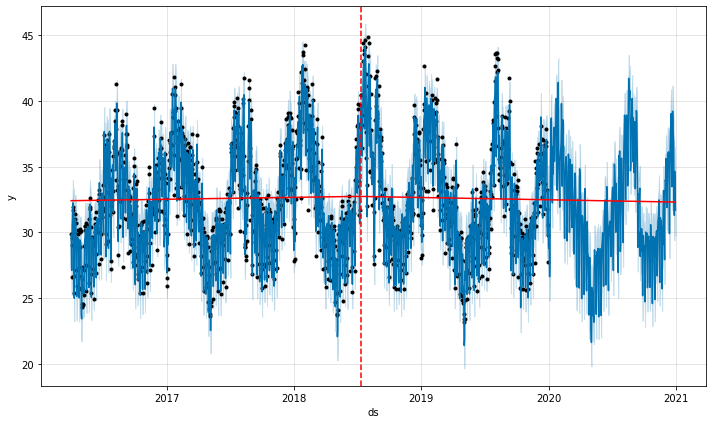

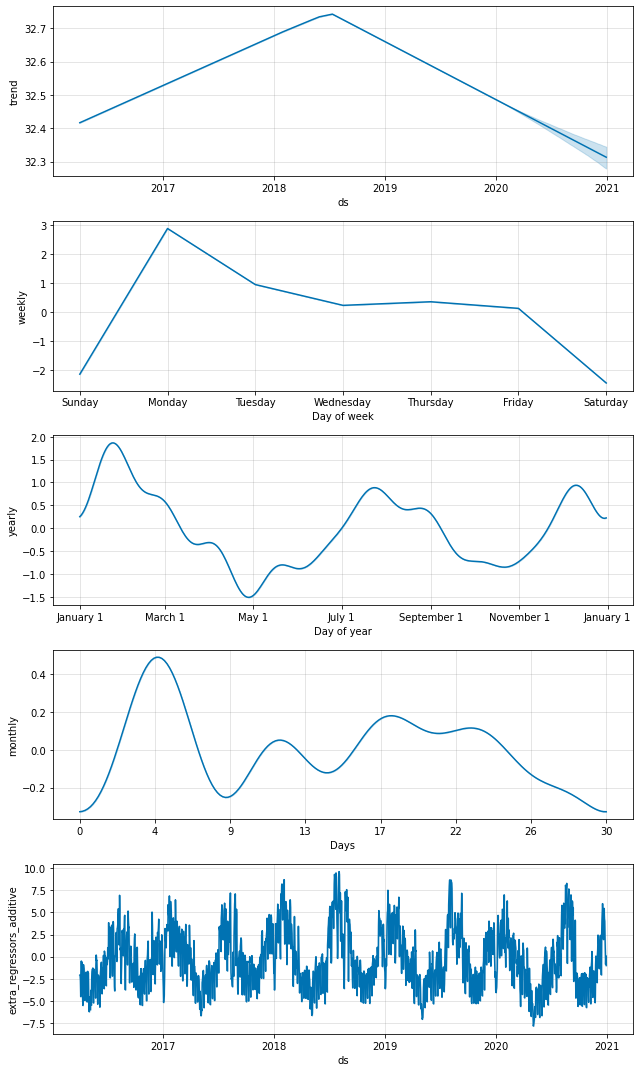

In [21]:
df_train = df[(df['ds'] < start)]
df_test = df[(df['ds']>= start) & (df['ds'] < end)]

data_train = df_train[['ds', 'y', 'temperature', 'gdp', 'y_shift_1']].copy()
data_test = df_test[['ds', 'y', 'temperature', 'gdp', 'y_shift_1']].copy()

prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.add_regressor('temperature')
prophet.add_regressor('gdp')
prophet.add_regressor('y_shift_1')

# prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=365, freq='D')

future = pd.merge(future, df[['ds', 'temperature', 'gdp', 'y_shift_1']], on='ds', how='left')  
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
# data_test.set_index('ds').plot()
plt.show()

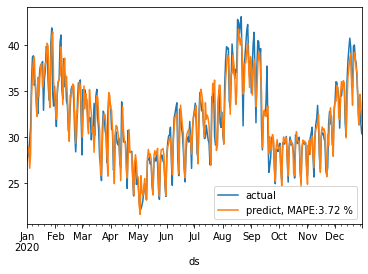

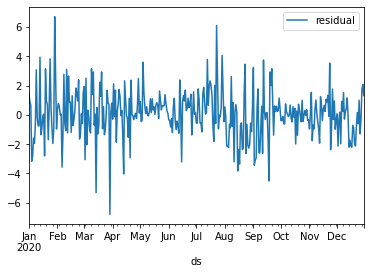

In [22]:
plot_prediction(forecast, data_test)

Jack Bera: 	 Jarque_beraResult(statistic=274.11538222169935, pvalue=0.0)


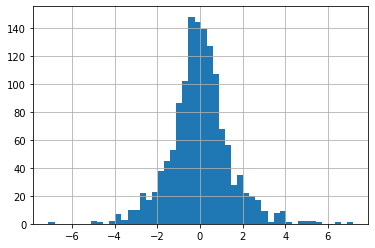

In [23]:
output = pd.merge(forecast, data_train, on='ds', how='left').set_index('ds')

cond = (output.index < start)
actual = output[cond]['y']
pred = output[cond]['yhat']

diff_arr = pred - actual

diff_arr.hist(bins=50)

jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

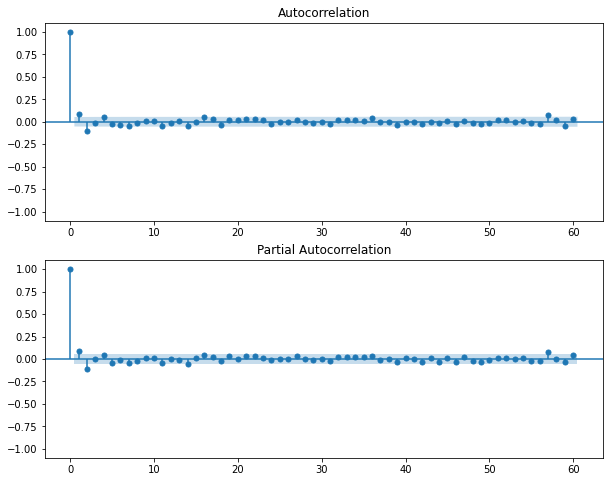

1 11.385165148260409 0.0007403297065516177
2 26.84684783465964 1.480065939699366e-06
3 27.271261289993802 5.164671696686497e-06
4 31.680928867171094 2.2229401510257667e-06
5 32.9605298822014 3.831960906151462e-06
6 34.42378752821034 5.571308038394879e-06
7 37.166428432383675 4.362138951012115e-06
8 37.64061975024714 8.770775071222143e-06
9 37.762349616180465 1.9228224772448036e-05
10 38.02648248614568 3.755096344315278e-05


/home/rnomura/.cache/pypoetry/virtualenvs/timeseries-KrZpyNEk-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [24]:
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

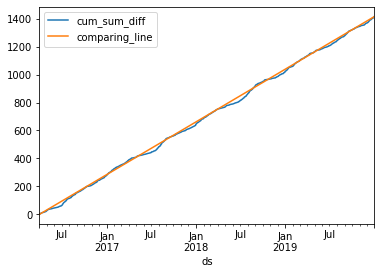

In [25]:
cum_arr = diff_arr.apply(np.abs).cumsum()

cum_min = cum_arr.min()
cum_max = cum_arr.max()

se_line = pd.Series(np.linspace(cum_min, cum_max, len(diff_arr)), index=diff_arr.index)

cum_arr.plot(label='cum_sum_diff')
se_line.plot(label='comparing_line')
plt.legend()
plt.show()

## さらに自己回帰項を入れる

In [26]:
df = pd.read_csv(INPUT_DIR + 'daily.csv')
df['ds'] = pd.to_datetime(df['date'])
df['y'] = df['power']

df_temperature = pd.read_csv(INPUT_DIR + 'daily_temperature.csv')
df_temperature['ds'] = pd.to_datetime(df_temperature['date'])

df_gdp = pd.read_csv(INPUT_DIR + 'daily_gdp.csv')
df_gdp['ds'] = pd.to_datetime(df_gdp['date'])

df = pd.merge(df[['ds', 'y']], df_temperature[['ds', 'temperature']], on='ds', how='left')
df = pd.merge(df, df_gdp[['ds', 'gdp']], on='ds', how='left')


df['y_shift_1'] = df['y'].shift(1).bfill()
df['y_shift_2'] = df['y'].shift(2).bfill()
df

,ds,y,temperature,gdp,y_shift_1,y_shift_2
0,2016-04-01,29.844167,12.8,134271.6,29.844167,29.844167
1,2016-04-02,29.074167,10.5,134271.6,29.844167,29.844167
2,2016-04-03,26.582500,13.1,134271.6,29.074167,29.844167
3,2016-04-04,29.562083,15.6,134271.6,26.582500,29.074167
4,2016-04-05,31.905000,10.8,134271.6,29.562083,26.582500
...,...,...,...,...,...,...
1816,2021-03-22,30.848333,NaN,NaN,26.930833,27.422083
1817,2021-03-23,31.999167,NaN,NaN,30.848333,26.930833
1818,2021-03-24,30.931667,NaN,NaN,31.999167,30.848333
1819,2021-03-25,30.563750,NaN,NaN,30.931667,31.999167


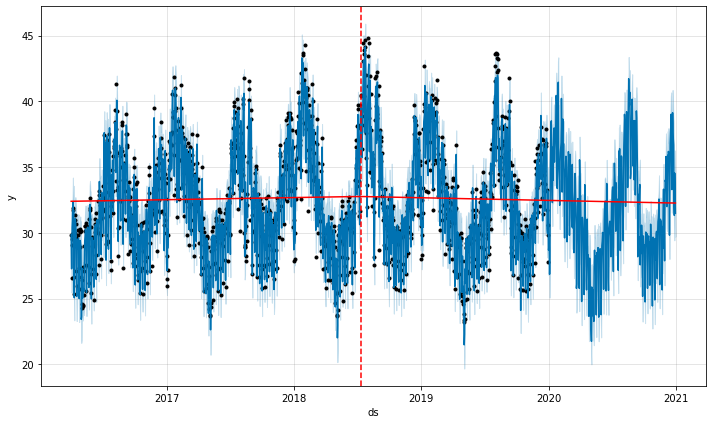

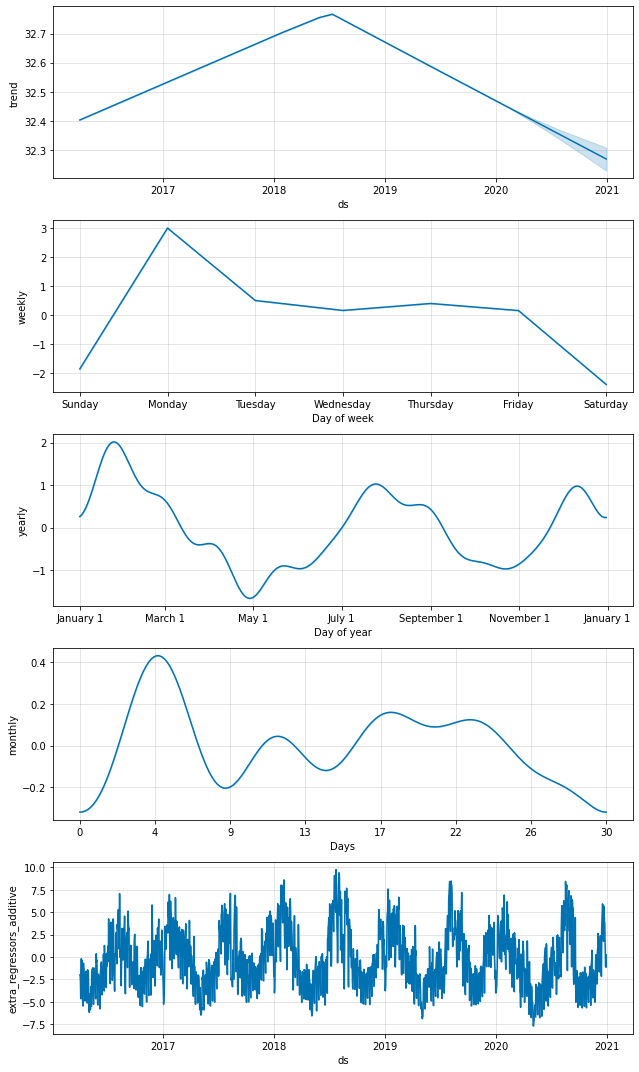

In [27]:
df_train = df[(df['ds'] < start)]
df_test = df[(df['ds']>= start) & (df['ds'] < end)]

data_train = df_train[['ds', 'y', 'temperature', 'gdp', 'y_shift_1', 'y_shift_2']].copy()
data_test = df_test[['ds', 'y', 'temperature', 'gdp', 'y_shift_1', 'y_shift_2']].copy()

prophet = Prophet(daily_seasonality=False,
                  weekly_seasonality=True,
                  yearly_seasonality=True,
                  seasonality_mode='additive')
prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.add_regressor('temperature')
prophet.add_regressor('gdp')
prophet.add_regressor('y_shift_1')
prophet.add_regressor('y_shift_2')

# prophet.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet.fit(data_train)
future = prophet.make_future_dataframe(periods=365, freq='D')

future = pd.merge(future, df[['ds', 'temperature', 'gdp', 'y_shift_1', 'y_shift_2']], on='ds', how='left')  
forecast = prophet.predict(future)
fig = prophet.plot(forecast)
a = add_changepoints_to_plot(fig.gca(), prophet, forecast)
prophet.plot_components(forecast)
# data_test.set_index('ds').plot()
plt.show()

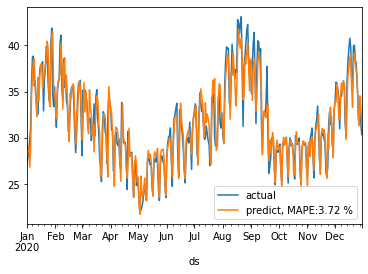

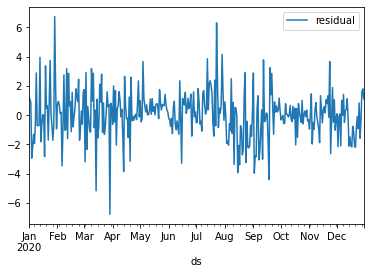

In [28]:
plot_prediction(forecast, data_test)

---ctt---
(-27.833127501198657, 0.0, 1, 1368, {'1%': -4.37962017688477, '5%': -3.8367137524285853, '10%': -3.5559379993530364}, 4746.125866050807)
---ct---
(-27.844553131578163, 0.0, 1, 1368, {'1%': -3.965403006131438, '5%': -3.413704202857358, '10%': -3.128942164554718}, 4744.15089726994)
---c---
(-27.854773518716712, 0.0, 1, 1368, {'1%': -3.435139190725917, '5%': -2.8636550704859007, '10%': -2.5678960623995417}, 4742.163284822377)
---nc---
(-27.865257680678976, 0.0, 1, 1368, {'1%': -2.5673762948214836, '5%': -1.9411981309292654, '10%': -1.616627288278372}, 4740.166095561981)


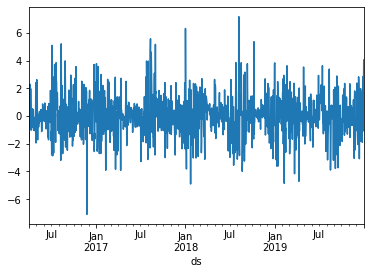

In [29]:
y = diff_arr
y.plot()
regs = ['ctt', 'ct', 'c', 'nc'] # 2次のトレンド＋定数項、1次のトレンド＋定数項, トレンドなし＋定数項、トレンド・定数項なし
for r in regs:
    print(f'---{r}---')
    print(sm.tsa.stattools.adfuller(y, regression=r))

Jack Bera: 	 Jarque_beraResult(statistic=265.1060098925638, pvalue=0.0)


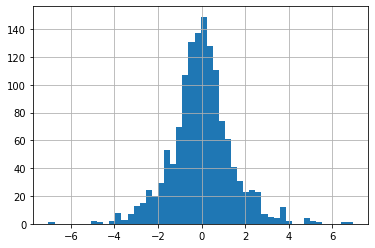

In [30]:
output = pd.merge(forecast, data_train, on='ds', how='left').set_index('ds')

cond = (output.index < start)
actual = output[cond]['y']
pred = output[cond]['yhat']

diff_arr = pred - actual

diff_arr.hist(bins=50)

jarque_bera_test = stats.jarque_bera(diff_arr)
print('Jack Bera:', '\t', jarque_bera_test)

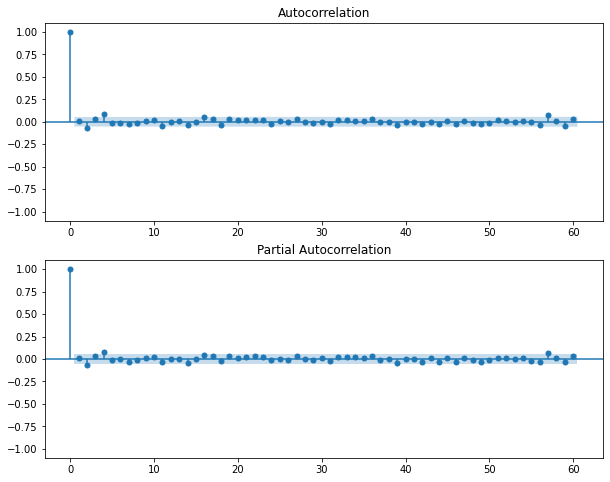

1 0.08744529956357577 0.7674504032802391
2 5.754426278151974 0.056291420801747545
3 6.710610720527925 0.08171650606147454
4 17.124954577282573 0.0018278214888227478
5 17.479188005657793 0.003675198570126829
6 17.59794532405389 0.007319567123774173
7 18.769256714070213 0.008941733675154818
8 18.88331591462235 0.015496285255218525
9 19.049763339701148 0.02477307748441362
10 19.54934394734863 0.033815092225552054


/home/rnomura/.cache/pypoetry/virtualenvs/timeseries-KrZpyNEk-py3.8/lib/python3.8/site-packages/statsmodels/stats/diagnostic.py:559: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


In [31]:
correlation_plot(diff_arr)

results = acorr_ljungbox(diff_arr, lags=10)
lag = 1
for lb, p in zip(results[0], results[1]):
    print(lag, lb, p)
    lag += 1

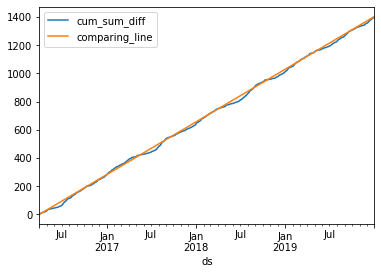

In [32]:
cum_arr = diff_arr.apply(np.abs).cumsum()

cum_min = cum_arr.min()
cum_max = cum_arr.max()

se_line = pd.Series(np.linspace(cum_min, cum_max, len(diff_arr)), index=diff_arr.index)

cum_arr.plot(label='cum_sum_diff')
se_line.plot(label='comparing_line')
plt.legend()
plt.show()